# Read/Write Benchmark Notebook
This notebook runs read/write benchmarks for SQLite, MongoDB, and ParquetDB across various row counts, then plots the results.

## Benchmark Details
- **Data Generation:** Generates 1,000,000 rows × 100 columns of integers (0–1,000,000). Integers are chosen as a basic primitive type—byte size is the main factor, so these results represent a **lower bound** on performance; more complex or larger types will incur higher cost.
- **Parquet Normalization (defaults):** row-group size 50,000–100,000 rows, max rows per file 10,000,000. Tuning these can shift performance between inserts, reads, and updates.

## System Specifications
- **Operating System:** Windows 10  
- **Processor:** AMD Ryzen 7 3700X 8‑Core @ 3.6 MHz (8 cores, 16 logical processors)   
- **Memory:** 128 GB DDR4‑3600 MHz (4×32 GB DIMMs) 
- **Storage**: SATA HDD 2TB (Model: ST2000DM008-2FR102)


## 1. Setup
Import libraries and define directories and parameters.

In [ ]:
!pip install parquetdb
!pip install pymongo

In [1]:
import os
import time
import random
import shutil
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pymongo import MongoClient
import pyarrow.compute as pc

from parquetdb import ParquetDB, config

# Directories
bench_dir = os.path.join(config.data_dir, 'benchmarks')
sqlite_dir = os.path.join(bench_dir, 'sqlite')
mongo_dir = os.path.join(bench_dir, 'mongodb')
pq_dir = os.path.join(bench_dir, 'parquetdb')
for d in (sqlite_dir, mongo_dir, pq_dir):
    os.makedirs(d, exist_ok=True)

row_counts = [1, 10, 100, 1_000, 10_000, 100_000, 1_000_000]
n_cols = 100

## 2. SQLite Read/Write Benchmark

In [2]:
def generate_data_sqlite(n_rows, n_cols=100):
    return [tuple(random.randint(0, 1_000_000) for _ in range(n_cols)) for _ in range(n_rows)]

def benchmark_read_write_sqlite(n_rows, db_file):
    if os.path.exists(db_file): os.remove(db_file)
    # Insert
    start = time.time()
    conn = sqlite3.connect(db_file)
    cols = ', '.join(f'col{i} INTEGER' for i in range(n_cols))
    conn.execute(f'CREATE TABLE t ({cols})')
    conn.execute('PRAGMA synchronous = OFF')
    conn.execute('PRAGMA journal_mode = MEMORY')
    placeholders = ', '.join('?' for _ in range(n_cols))
    conn.executemany(f'INSERT INTO t VALUES ({placeholders})', generate_data_sqlite(n_rows, n_cols))
    conn.commit()
    conn.close()
    insert_time = time.time() - start

    # Read (with index on col0)
    conn = sqlite3.connect(db_file)
    conn.execute('CREATE INDEX IF NOT EXISTS idx_col0 ON t(col0)')
    conn.commit()
    conn.close()
    start = time.time()
    conn = sqlite3.connect(db_file)
    cur = conn.cursor()
    cur.execute('SELECT * FROM t')
    _ = cur.fetchall()
    conn.close()
    read_time = time.time() - start
    return insert_time, read_time

# Run SQLite benchmark
results_sql = {'n_rows': [], 'insert': [], 'read': []}
db_file = os.path.join(sqlite_dir, 'benchmark.db')
for n in row_counts:
    it, rt = benchmark_read_write_sqlite(n, db_file)
    results_sql['n_rows'].append(n)
    results_sql['insert'].append(it)
    results_sql['read'].append(rt)
df_sql = pd.DataFrame(results_sql)
df_sql.to_csv(os.path.join(sqlite_dir, 'sqlite_benchmark.csv'), index=False)
df_sql.head()

n_rows    insert      read
0       1  0.107998  0.000998
1      10  0.116234  0.002001
2     100  0.105669  0.003000
3    1000  0.190102  0.017001
4   10000  0.849536  0.168004

## 3. MongoDB Read/Write Benchmark

In [3]:
def generate_data_mongo(n_rows, n_cols=100):
    return [{f'col_{i}': random.randint(0, 1_000_000) for i in range(n_cols)} for _ in range(n_rows)]

def benchmark_read_write_mongo(n_rows, client, db_name='benchmark'):
    client.drop_database(db_name)
    start = time.time()
    coll = client[db_name].t
    coll.insert_many(generate_data_mongo(n_rows, n_cols))
    insert_time = time.time() - start

    start = time.time()
    list(coll.find({}))
    read_time = time.time() - start
    return insert_time, read_time

# Run MongoDB benchmark
client = MongoClient('mongodb://localhost:27017/')
results_mg = {'n_rows': [], 'insert': [], 'read': []}
for n in row_counts:
    it, rt = benchmark_read_write_mongo(n, client)
    results_mg['n_rows'].append(n)
    results_mg['insert'].append(it)
    results_mg['read'].append(rt)
df_mg = pd.DataFrame(results_mg)
df_mg.to_csv(os.path.join(mongo_dir, 'mongodb_benchmark.csv'), index=False)
client.close()
df_mg.head()

n_rows    insert      read
0       1  0.011999  0.002002
1      10  0.011999  0.001001
2     100  0.024998  0.003001
3    1000  0.122996  0.020001
4   10000  1.148678  0.294522

## 4. ParquetDB Read/Write Benchmark

In [4]:
from parquetdb.utils import general_utils

def benchmark_read_write_pq(n_rows, db_path):
    if os.path.exists(db_path): shutil.rmtree(db_path)
    db = ParquetDB(db_path)
    start = time.time()
    data = general_utils.generate_pylist_data(n_rows=n_rows, min_value=0, max_value=1_000_000)
    db.create(data)
    insert_time = time.time() - start

    start = time.time()
    _ = db.read()
    read_time = time.time() - start
    return insert_time, read_time

# Run ParquetDB benchmark
results_pq = {'n_rows': [], 'insert': [], 'read': []}
db_path = os.path.join(pq_dir, 'BenchmarkDB')
for n in row_counts:
    it, rt = benchmark_read_write_pq(n, db_path)
    results_pq['n_rows'].append(n)
    results_pq['insert'].append(it)
    results_pq['read'].append(rt)
df_pq = pd.DataFrame(results_pq)
df_pq.to_csv(os.path.join(pq_dir, 'parquetdb_benchmark.csv'), index=False)
df_pq.head()

[INFO] 2025-04-19 13:11:42 - parquetdb.core.parquetdb[205][__init__] - Initializing ParquetDB with db_path: Z:\data\parquetdb\data\benchmarks\parquetdb\BenchmarkDB
[INFO] 2025-04-19 13:11:42 - parquetdb.core.parquetdb[207][__init__] - verbose: 1


n_rows    insert      read
0       1  0.082995  0.015001
1      10  0.058997  0.015002
2     100  0.132612  0.013999
3    1000  0.199732  0.014002
4   10000  1.186683  0.017001

## 5. Load & Preview Results

In [2]:
df_sql = pd.read_csv(os.path.join(sqlite_dir, 'sqlite_benchmark.csv'))
df_mg  = pd.read_csv(os.path.join(mongo_dir, 'mongodb_benchmark.csv'))
df_pq  = pd.read_csv(os.path.join(pq_dir, 'parquetdb_benchmark.csv'))
df_sql.head(), df_mg.head(), df_pq.head()

(   n_rows    insert      read
 0       1  0.107998  0.000998
 1      10  0.116234  0.002001
 2     100  0.105669  0.003000
 3    1000  0.190102  0.017001
 4   10000  0.849536  0.168004,
    n_rows    insert      read
 0       1  0.011999  0.002002
 1      10  0.011999  0.001001
 2     100  0.024998  0.003001
 3    1000  0.122996  0.020001
 4   10000  1.148678  0.294522,
    n_rows    insert      read
 0       1  0.082995  0.015001
 1      10  0.058997  0.015002
 2     100  0.132612  0.013999
 3    1000  0.199732  0.014002
 4   10000  1.186683  0.017001)

## 6. Plot Create & Read Times

C:\Users\lllang\AppData\Local\Temp\ipykernel_17352\263859993.py:204: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


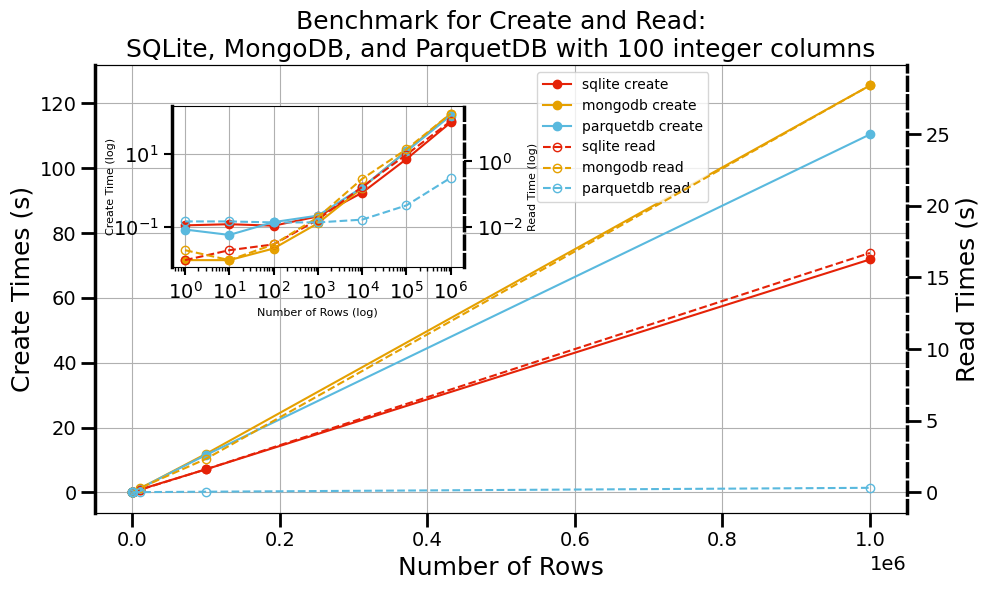

In [3]:
plt.rcParams.update({
    'axes.labelsize': 18, 'axes.titlesize': 18,
    'xtick.labelsize': 14, 'ytick.labelsize': 14
})

benchmark_dirs=[sqlite_dir,mongo_dir,pq_dir]
n_rows=df_pq['n_rows']

fig, ax1 = plt.subplots(figsize=(10, 6))

# colors, styles
colors = {"sqlite": "#e52207", "mongodb": "#e5a000", "parquetdb": "#59b9de"}
line_styles = {"create_times": "solid", "read_times": "dashed"}
marker_styles = {"sqlite": "o", "mongodb": "o", "parquetdb": "o"}
marker_fill = {
    "sqlite": {"create_times": "full", "read_times": "none"},
    "mongodb": {"create_times": "full", "read_times": "none"},
    "parquetdb": {"create_times": "full", "read_times": "none"},
}

# # primary: create times
# for benchmark_dir in benchmark_dirs:
#     name = os.path.basename(benchmark_dir)
#     df = pd.read_csv(os.path.join(benchmark_dir, f"{name}_benchmark.csv"))
ax1.plot(
    n_rows,
    df_sql["insert"],
    label=f"sqlite create",
    color=colors["sqlite"],
    linestyle=line_styles["create_times"],
    marker=marker_styles["sqlite"],
    fillstyle=marker_fill["sqlite"]["create_times"],
)

ax1.plot(
    n_rows,
    df_mg["insert"],
    label=f"mongodb create",
    color=colors["mongodb"],
    linestyle=line_styles["create_times"],
    marker=marker_styles["mongodb"],
    fillstyle=marker_fill["mongodb"]["create_times"],
)

ax1.plot(
    n_rows,
    df_pq["insert"],
    label=f"parquetdb create",
    color=colors["parquetdb"],
    linestyle=line_styles["create_times"],
    marker=marker_styles["parquetdb"],
    fillstyle=marker_fill["parquetdb"]["create_times"],
)

# secondary: read times
ax2 = ax1.twinx()

ax2.plot(
    n_rows,
    df_sql["read"],
    label=f"sqlite read",
    color=colors["sqlite"],
    linestyle=line_styles["read_times"],
    marker=marker_styles["sqlite"],
    fillstyle=marker_fill["sqlite"]["read_times"],
)
ax2.plot(
    n_rows,
    df_mg["read"],
    label=f"mongodb read",
    color=colors["mongodb"],
    linestyle=line_styles["read_times"],
    marker=marker_styles["mongodb"],
    fillstyle=marker_fill["mongodb"]["read_times"]
    )
ax2.plot(
    n_rows,
    df_pq["read"],
    label=f"parquetdb read",
    color=colors["parquetdb"],
    linestyle=line_styles["read_times"],
    marker=marker_styles["parquetdb"],
    fillstyle=marker_fill["parquetdb"]["read_times"],
)



# labels & styling
ax1.set_xlabel("Number of Rows")
ax1.set_ylabel("Create Times (s)")
ax2.set_ylabel("Read Times (s)")
ax1.spines["left"].set_linestyle(line_styles["create_times"])
ax1.spines["left"].set_linewidth(2.5)
ax2.spines["right"].set_linestyle(line_styles["read_times"])
ax2.spines["right"].set_linewidth(2.5)
ax1.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax1.tick_params(axis="both", which="major", length=10, width=2, direction="out")
ax2.tick_params(axis="both", which="major", length=10, width=2, direction="out")
ax1.grid(True)

# inset log–log
scale = 36
ax_inset = inset_axes(
    ax1,
    width=f"{scale}%",
    height=f"{scale}%",
    loc="upper left",
    bbox_to_anchor=(0.06, -0.03, 1, 1),
    bbox_transform=ax1.transAxes,
    borderpad=2,
)
ax_inset.grid(True)

# inset create
ax_inset.plot(
    n_rows,
    df_sql["insert"],
    label=f"sqlite create",
    color=colors["sqlite"],
    linestyle=line_styles["create_times"],
    marker=marker_styles["sqlite"],
    fillstyle=marker_fill["sqlite"]["create_times"],
)

ax_inset.plot(
    n_rows,
    df_mg["insert"],
    label=f"mongodb create",
    color=colors["mongodb"],
    linestyle=line_styles["create_times"],
    marker=marker_styles["mongodb"],
    fillstyle=marker_fill["mongodb"]["create_times"],
)

ax_inset.plot(
    n_rows,
    df_pq["insert"],
    label=f"parquetdb create",
    color=colors["parquetdb"],
    linestyle=line_styles["create_times"],
    marker=marker_styles["parquetdb"],
    fillstyle=marker_fill["parquetdb"]["create_times"],
)
# inset read
ax_inset2 = ax_inset.twinx()
ax_inset2.plot(
    n_rows,
    df_sql["read"],
    label=f"sqlite read",
    color=colors["sqlite"],
    linestyle=line_styles["read_times"],
    marker=marker_styles["sqlite"],
    fillstyle=marker_fill["sqlite"]["read_times"],
)
ax_inset2.plot(
    n_rows,
    df_mg["read"],
    label=f"mongodb read",
    color=colors["mongodb"],
    linestyle=line_styles["read_times"],
    marker=marker_styles["mongodb"],
    fillstyle=marker_fill["mongodb"]["read_times"]
    )
ax_inset2.plot(
    n_rows,
    df_pq["read"],
    label=f"parquetdb read",
    color=colors["parquetdb"],
    linestyle=line_styles["read_times"],
    marker=marker_styles["parquetdb"],
    fillstyle=marker_fill["parquetdb"]["read_times"],
)


# log scales & labels
ax_inset.set_xscale("log")
ax_inset.set_yscale("log")
ax_inset2.set_yscale("log")
ax_inset.set_xlabel("Number of Rows (log)", fontsize=8)
ax_inset.set_ylabel("Create Time (log)", fontsize=8, labelpad=-2)
ax_inset2.set_ylabel("Read Time (log)", fontsize=8)

maj = ticker.LogLocator(numticks=9)
minr = ticker.LogLocator(subs="all", numticks=9)
ax_inset.xaxis.set_major_locator(maj)
ax_inset.xaxis.set_minor_locator(minr)
ax_inset.spines["left"].set_linestyle(line_styles["create_times"])
ax_inset.spines["left"].set_linewidth(2.5)
ax_inset2.spines["right"].set_linestyle(line_styles["read_times"])
ax_inset2.spines["right"].set_linewidth(2.5)
ax_inset.spines["right"].set_visible(False)
ax_inset2.spines["left"].set_visible(False)
ax_inset.tick_params(axis="both", which="major", length=6, width=1.5, direction="out")
ax_inset.tick_params(axis="x", which="minor", length=3, width=1, direction="out")
ax_inset.tick_params(axis="y", which="minor", length=3, width=1, direction="out")
ax_inset2.tick_params(axis="both", which="major", length=6, width=1.5, direction="out")

# legend & title
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.15, 0, 1, 1))
ax1.set_title("Benchmark for Create and Read:\nSQLite, MongoDB, and ParquetDB with 100 integer columns")
plt.tight_layout()

plt.savefig(os.path.join(bench_dir,"create-read_benchmark.pdf"))
plt.show()


## 6. Dicussion

1. **Create performance hierarchy**  
   - **SQLite** remains the fastest writer across all scales, thanks to its optimized C‑API and lightweight on‑disk format.  
   - **ParquetDB** comes in **2nd**, with linear growth in create time driven by Arrow serialization and file I/O.  
   - **MongoDB** trails slightly behind ParquetDB, reflecting the overhead of BSON encoding and network/driver layers.

2. **Read (full‑table scan) performance**  
   - **ParquetDB** is the clear winner on raw reads: it returns a ready‑to‑use PyArrow table in one shot, avoiding any Python‑level loops.  
   - **SQLite** and **MongoDB** both require iterating over each row in Python (via a cursor or cursor-like API), accumulating values into a list, this per‑row overhead dominates their read times, resulting in roughly linear growth up to ~16 s at 1 M rows.

3. **Input format caveat**  
   - All ParquetDB create times above were measured using a **Python list of row‑dicts (pylist)**, our worst‑case input. As shown in the Input Update benchmark, switching to columnar inputs (pandas or native PyArrow tables) can significantly reduce ParquetDB’s create latency.


4. **Key takeaways**  
   - If your workload is **write‑heavy**, SQLite still leads for small to moderate datasets—but ParquetDB’s throughput is competitive and gains further speed with columnar inputs.  
   - If you need **fast full‑table reads** into analytical pipelines, ParquetDB outperforms both row‑stores by avoiding Python‑loop overhead and leveraging Arrow’s zero‑copy data structures.
